In [139]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [140]:
# set your results file path
baseline_results = "<your path>/output/default/baseline/<your model name>/ntask_nshot/results.csv" 
llicl_dir = "<your path>/output/default/recall/<your model name>"
n_shot = 2
n_task = 32

baseline_df = pd.read_csv(baseline_results, index_col=0)
baseline_df.head()

selected_results = baseline_df[baseline_df["n_shot_per_class"] == n_shot]
mean_accuracy = selected_results.groupby("task_name")["accuracy"].mean()
std_accuracy = selected_results.groupby("task_name")["accuracy"].std()

result = pd.concat([mean_accuracy, std_accuracy], axis=1)
result.columns = ['mean_accuracy', 'std_accuracy']  # Rename columns if needed

print(result)

                          mean_accuracy  std_accuracy
task_name                                            
ag_news                           0.842      0.017889
amazon_counterfactual_en          0.668      0.053572
amazon_massive_scenario           0.796      0.023022
app_reviews                       0.652      0.027749
beaver_tails                      0.682      0.052631
...                                 ...           ...
wic                               0.572      0.016432
wiki_hades                        0.562      0.033466
wiki_qa                           0.686      0.041593
wsc                               0.484      0.049295
yahoo_answers_topics              0.558      0.046583

[64 rows x 2 columns]


In [141]:
permutations = os.path.join(llicl_dir, f"ntask{n_task}_nshot{n_shot}", "permutations.csv")
permutations = pd.read_csv(permutations, index_col=0)
permutations.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,wiki_qa,covid_fake_news,metaphor_boolean,brag_action,climate_fever,qqp,dbpedia_14,wiki_hades,emo,poem_sentiment,...,boolq,trec,clickbait,sst5,logical_fallacy_detection,sst2,amazon_massive_scenario,this_is_not_a_dataset,yahoo_answers_topics,imdb
1,poem_sentiment,brag_action,dbpedia_14,clickbait,cola,this_is_not_a_dataset,emo,semeval_absa_restaurant,boolq,sst2,...,pun_detection,yahoo_answers_topics,amazon_massive_scenario,liar,covid_fake_news,news_data,metaphor_boolean,wiki_qa,imdb,qqp
2,clickbait,boolq,brag_action,insincere_questions,liar,imdb,logical_fallacy_detection,yahoo_answers_topics,sst2,metaphor_boolean,...,emo,amazon_massive_scenario,covid_fake_news,amazon_counterfactual_en,is_humor,trec,pun_detection,news_data,sst5,ag_news
3,liar,clickbait,climate_fever,amazon_massive_scenario,boolq,wiki_hades,insincere_questions,dbpedia_14,brag_action,cola,...,covid_fake_news,this_is_not_a_dataset,trec,yahoo_answers_topics,wsc,sst2,pun_detection,ag_news,is_humor,sst5
4,wsc,sms_spam,qqp,covid_fake_news,poem_sentiment,metaphor_boolean,emo,wiki_hades,ag_news,brag_action,...,semeval_absa_restaurant,cola,amazon_counterfactual_en,clickbait,climate_fever,copa,wiki_qa,amazon_massive_scenario,trec,boolq


In [142]:

llicl_results = os.path.join(llicl_dir, f"ntask{n_task}_nshot{n_shot}", "results.csv")
llicl_results = pd.read_csv(llicl_results, index_col=0)
llicl_results.head()

,n_task,n_shot,permutation_id,fewshot_sample_id,global_prefix_n_tokens,task_name,accuracy,macro_f1,ood_rate
0,32,2,0,0,14566,covid_fake_news,0.84,0.826389,0.0
1,32,2,0,0,14566,amazon_counterfactual_en,0.88,0.592391,0.0
2,32,2,0,0,14566,semeval_absa_restaurant,0.81,0.555081,0.0
3,32,2,0,0,14566,emo,0.63,0.435380,0.0
4,32,2,0,0,14566,dbpedia_14,0.78,0.725702,0.0


In [143]:
task_list = llicl_results["task_name"].unique().tolist()
n_task = len(task_list)
# task_list

In [144]:
agg = {task_name: [[] for _ in range(len(task_list))] for task_name in task_list}

In [145]:
def get_loc(perm_id, permutations, task_name):
    perm_row = permutations.iloc[perm_id]
    column_number = [i for i, value in enumerate(perm_row) if value == task_name]
    return column_number[0]

In [146]:
for index, row in llicl_results.iterrows():
    task_name = row["task_name"]
    loc = get_loc(row["permutation_id"], permutations, task_name)
    agg[task_name][loc].append(row["accuracy"])

In [147]:
avg_agg = {task_name: [0.0 for _ in range(len(task_list))] for task_name in task_list}
for task in task_list:
    for i in range(len(task_list)):
        avg_agg[task][i] = np.mean(agg[task][i]) if len(agg[task][i]) > 0 else -100

In [148]:
avg_delta = avg_agg.copy()
for i, task_name in enumerate(task_list):
    avg_delta[task_name] = avg_agg[task_name] - mean_accuracy.loc[task_name]
# avg_delta

In [149]:
from scipy.stats import ttest_ind, ttest_rel
sign = lambda x: (1, -1)[x<0]


In [150]:
# statistical test

final_agg = {task_name: [[] for _ in range(len(task_list))] for task_name in task_list}
episode_agg = {idx: [0.0 for _ in range(len(task_list))] for idx in range(5)}

n_shot = 4

for perm_id in range(5):
    for task_name in task_list:
        sub_df = llicl_results[(llicl_results["task_name"] == task_name) & (llicl_results["permutation_id"] == perm_id)]
        baseline_sub_df = baseline_df[(baseline_df["task_name"] == task_name) & (baseline_df["n_shot_per_class"] == n_shot)]
        loc = get_loc(perm_id, permutations, task_name)
        t, p = ttest_rel(sub_df['accuracy'], baseline_sub_df['accuracy'])
        pass_or_not = sign(t) * int(p < 0.05) # 1: pass; -1: not pass
        final_agg[task_name][loc].append(pass_or_not)
        episode_agg[perm_id][loc] = pass_or_not



/tmp/ipykernel_37419/3507534729.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]


In [151]:
for task in task_list:
    for j in range(len(task_list)):
        final_agg[task][j] = np.mean(final_agg[task][j]) if len(final_agg[task][j])>0 else np.nan

In [152]:
import matplotlib.colors as mcolors

def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'truncated({},{:.2f},{:.2f})'.format(cmap.name, min_val, max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap
cmap = truncate_colormap(plt.cm.RdBu, 0.25, 0.75)
cmap.set_bad(color='lightgrey')  # You can set this to any color you like

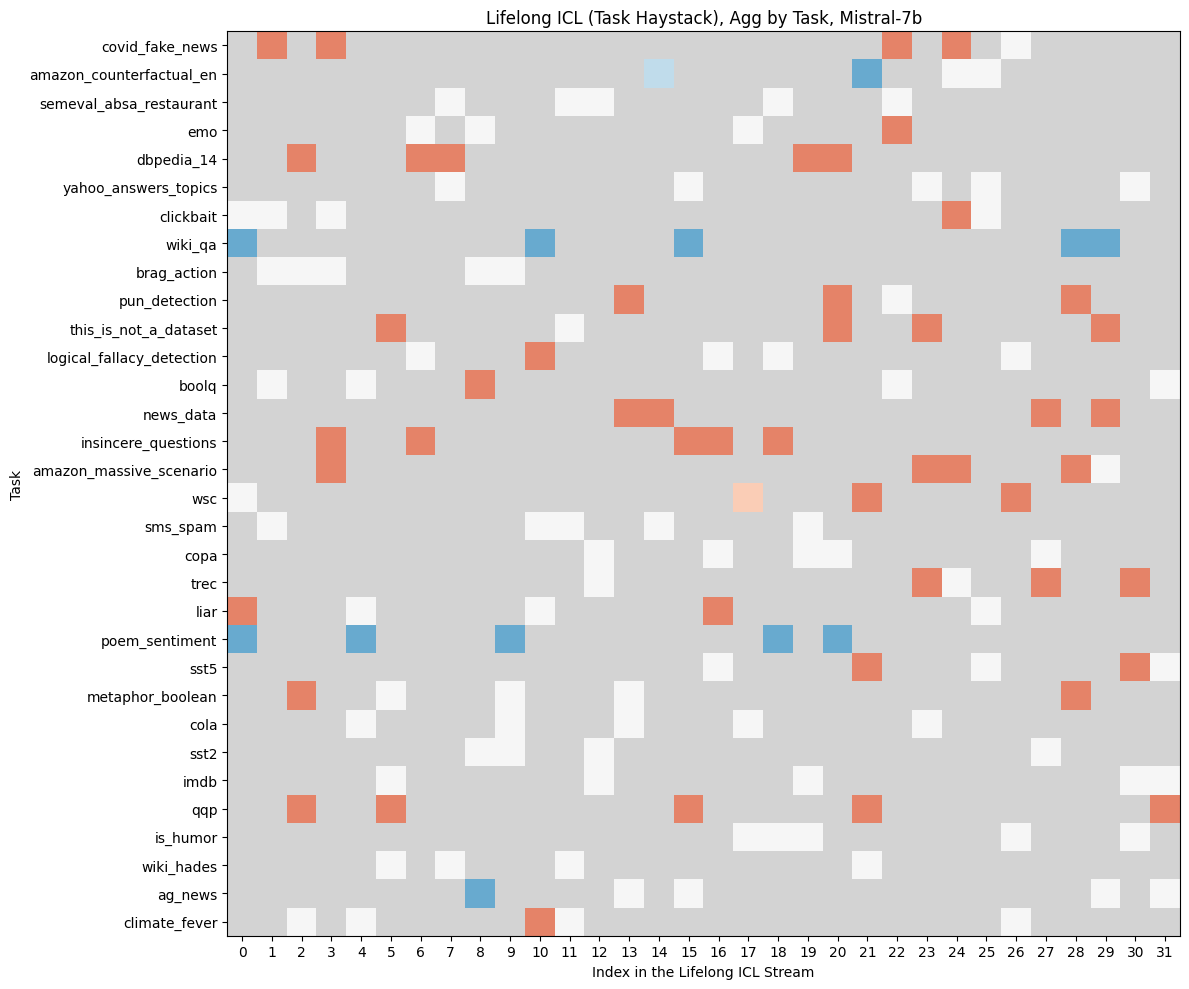

In [153]:

# Convert the dictionary to a list of lists
# Convert the dictionary to a list of lists and transpose it
data = avg_delta

matrix = np.array([final_agg[key] for key in final_agg])
masked_data = np.ma.masked_invalid(matrix)

# Plotting
plt.figure(figsize=(12, 10))

plt.imshow(matrix, cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add color bar
# plt.colorbar(label='Accuracy Delta')

# Set tick labels
plt.yticks(np.arange(len(matrix)), list(data.keys()))
plt.xticks(np.arange(len(data)), range(len(data)))

# Set labels and title
plt.ylabel('Task')
plt.xlabel('Index in the Lifelong ICL Stream')
plt.title('Lifelong ICL (Task Haystack), Agg by Task, Mistral-7b')

plt.tight_layout()
plt.show()

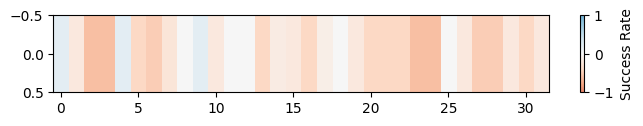

In [154]:
avg_for_idx = np.nanmean(matrix, axis=0)
plt.figure(figsize=(8, 1))
plt.imshow(avg_for_idx[np.newaxis,:], cmap=cmap, aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Success Rate')

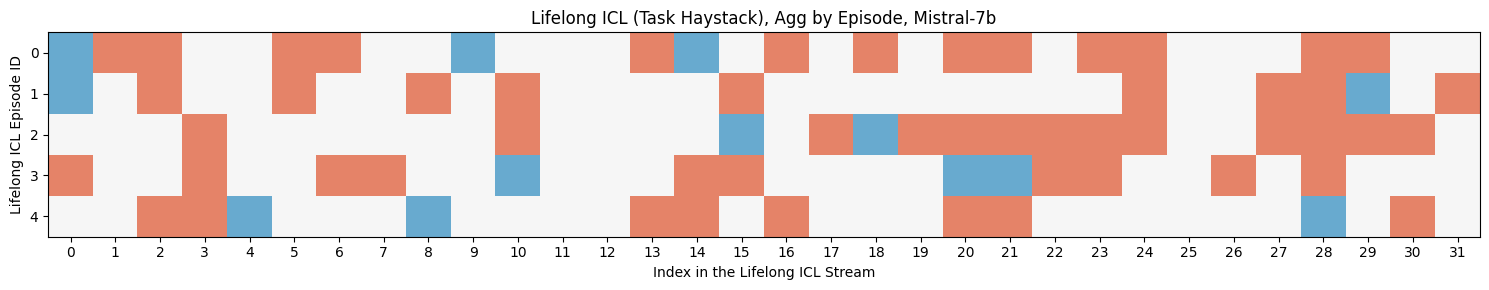

In [155]:

# Convert the dictionary to a list of lists
# matrix = [final_agg[key] for key in final_agg]
# Convert the dictionary to a list of lists and transpose it
matrix = np.array([episode_agg[key] for key in episode_agg])

# Plotting
plt.figure(figsize=(15, 3))


plt.imshow(matrix, cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add color bar
# plt.colorbar(label='Accuracy Delta')

# Set tick labels
plt.yticks(np.arange(len(matrix)), list(episode_agg.keys()))
plt.xticks(np.arange(len(matrix[0])), range(len(matrix[0])))

# Set labels and title
plt.ylabel('Lifelong ICL Episode ID')
plt.xlabel('Index in the Lifelong ICL Stream')
plt.title('Lifelong ICL (Task Haystack), Agg by Episode, Mistral-7b')

plt.tight_layout()
plt.show()